# Community Detection in a Blog network

Reference for the data :

@inproceedings{nr-aaai15,
      title = {The Network Data Repository with Interactive Graph Analytics and Visualization},
      author={Ryan A. Rossi and Nesreen K. Ahmed},
      booktitle = {AAAI},
      url={http://networkrepository.com},
      year={2015}
  }

## 0) Import Libraries

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import heapq

## 1) Dataset

### Load the data set

Reference for opening mtx file using scipy.io mmread function : https://www.programcreek.com/python/example/101880/scipy.io.mmread

In [2]:
G = nx.read_edgelist('dataset/soc-BlogCatalog.txt', nodetype=int, data=(int,int))

### Explore the properties of the graph

General information of the graph :

In [3]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 88784
Number of edges: 2093195
Average degree:  47.1525


What is the maximum degree a node has ?

In [4]:
nodes = G.nodes
maxDegree = max(G.degree[node] for node in nodes)
maxDegree

9444

What is the minimum degree a node has ?

In [5]:
nodes = G.nodes
minDegree = min(G.degree[node] for node in nodes)
minDegree

1

Is there some cycle in our graph ?

In [6]:
nx.find_cycle(G)

[(1, 3), (3, 7), (7, 1)]

What about triangles ?

In [7]:
#nx.triangles(G)

## 2) Implementation

### Create a smaller graph 
#### we will use it as an example to demonstrate the functions

/Users/nanaeaubry/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


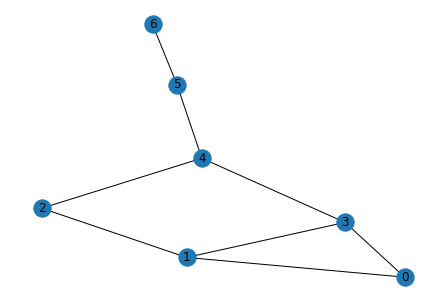

In [8]:
X = nx.Graph()
X.add_edges_from([(0, 1), (0, 3), (1,3), (1,2), (3,4), (5,6), (4,5), (2,4)])
nx.draw(X, with_labels=True)
plt.show()

### Edge Betweenness Algo

[Girvan Newman by Anuradha Bhatia](https://www.youtube.com/watch?v=LtQoPEKKRYM)

In [9]:
def _single_source_shortest_path_basic(G, s):
    
    shortest_path = []
    predecessors = {}
    for v in G:
        predecessors[v] = []
     
    sigma = dict.fromkeys(G, 0.0)
    sigma[s] = 1.0

    D = {}
    D[s] = 0
    
    queue = [s]
    
    # use BFS to find shortest paths
    while queue: 
        v = queue.pop(0)
        shortest_path.append(v)
        Dv = D[v]
        sigmav = sigma[v]
        for w in G[v]:
            if w not in D:
                queue.append(w)
                D[w] = Dv + 1
                
            if D[w] == Dv + 1:   # this is a shortest path, count paths
                sigma[w] += sigmav
                predecessors[w].append(v)  # predecessors
                
    return shortest_path, predecessors, sigma

def _accumulate_edges(betweenness, shortest_path, predecessors, sigma, s):
    
    delta = dict.fromkeys(shortest_path, 0)
    while shortest_path:
        w = shortest_path.pop()
        coeff = (1 + delta[w]) / sigma[w]
        for v in predecessors[w]:
            c = sigma[v] * coeff
            if (v, w) not in betweenness:
                betweenness[(w, v)] += c
            else:
                betweenness[(v, w)] += c
            delta[v] += c
        if w != s:
            betweenness[w] += delta[w]
            
    return betweenness

def edge_betweenness_centrality(G):
    
    # b[v]=0 for v in G
    betweenness = dict.fromkeys(G, 0.0)  
    
    # b[e]=0 for e in G.edges()
    betweenness.update(dict.fromkeys(G.edges(), 0.0))
    
    for n in G:
        
        # use BFS
        shortest_path, predecessors, sigma = _single_source_shortest_path_basic(G, n)
        
        # accumulation
        betweenness = _accumulate_edges(betweenness, shortest_path, predecessors, sigma, n)
        
    # rescaling
    for n in G:  # remove nodes to only return edges
        del betweenness[n]

    for e in betweenness:
        betweenness[e] *= 0.5
    
    return betweenness

#### We can now calcualte the betweenness for our smaller graph X. Here we will receive a list of betweenness values for each edge in the graph

In [10]:
betweenness = edge_betweenness_centrality(X)
betweenness

{(0, 1): 2.0,
 (0, 3): 4.0,
 (1, 3): 3.0,
 (1, 2): 4.0,
 (3, 4): 8.0,
 (2, 4): 5.0,
 (4, 5): 10.0,
 (5, 6): 6.0}

#### The edge with the maximum betweeness is given by the call below and this will be the edge that should first be removed when we run the Girvan Newman algorithm

In [11]:
max(betweenness, key=betweenness.get)

(4, 5)

### Girvan Newman Algo

##### This method keeps removing edges with maximum betweenness from Graph until splits into two communities

In [12]:
def girvan_newman(G):

    # no of components
    initial_number_components = nx.number_connected_components(G)    
    
    # stop when we have more communities compare to when we started
    current_number_components = initial_number_components
    while current_number_components <= initial_number_components:
        
        # edge betweenness for G
        bw = edge_betweenness_centrality(G)   
        
        # find the edge with max centrality (n1, n2)
        central_edge = max(bw, key=bw.get)
        
        #remove the central edge
        G.remove_edge(central_edge[0],central_edge[1])  
        
        # recalculate the no of components
        current_number_components = nx.number_connected_components(G)

#### We can run the Girvan Newman algorithm on our small graph now and see the communities that are found

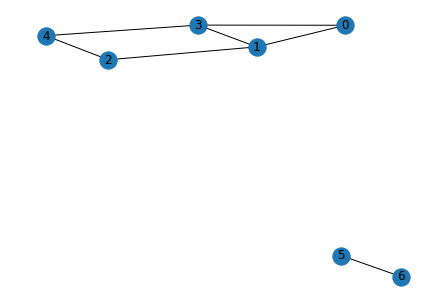

In [13]:
girvan_newman(X)

nx.draw(X, with_labels=True)
plt.show()

#### After having seen the effects on our small graph let's apply it to the entire network
Since there are 2.1M edges, it will take a while to compute the betweenness for each edge. The program will spend a lot of time in the algorithm that calculates the shortest path.

In [14]:
girvan_newman(G)

nx.draw(G, with_labels=True)
plt.show()


KeyboardInterrupt: 

### Implement the Degree centrality measure

The degree centrality of a node is simply its degree, which is the number of edges which are connected to it.

Let's take an example with the node 10 and calculte its degree :

In [ ]:
nodetendegree = G.degree[10]
print("Node 10 has degree "+str(nodetendegree))
print("It is linked to the following nodes :"+str([n for n in G[10]]))

However, the degree centrality of a node is usually normalized, so this is what we are going to do :

In [ ]:
normalized_degree = nodetendegree / (len(G.nodes)-1)
print("Normalized degree of node 10 : "+str(normalized_degree))

##### Now we will implement a function which computes the normalized degree centrality for every node and return it in a dictionnary:

In [ ]:
def degree_centrality_measure(G):
    nodes = G.nodes
    number_of_nodes = len(nodes)
    max_possible_degree = (number_of_nodes-1)
    results = dict()
    for node in nodes:
        normalized_degree = G.degree[node] / max_possible_degree
        results[node] = normalized_degree
    return results

Let's see if it works by finding the node with the highest degree centrality :

In [ ]:
degreeC = degree_centrality_measure(G)
maxDegreeCentralityNode = max(degreeC, key=degreeC.get)
maxDegreeCentralityValue = max(degreeC.values())
print("The node which has the highest degree centrality is the node "
      +str(maxDegreeCentralityNode)+" with a value of : "+str(maxDegreeCentralityValue))

## 3) Analysis

### Identify users’ communities in the blog network using Girvan-Newman. Evaluate with different values of the iteration level.

### Identify the top k users with the highest Degree centrality in the graph. Experiment with different values of k and choose the most appropriate one.

Let's create a function which list the top k users with highest Degree centrality :

In [ ]:
def k_nodes_max_degreeC(dictionary, k):
    k_nodes = heapq.nlargest(k, dictionary, key=dictionary.get)
    results = dict()
    for node in k_nodes:
        results[node] = dictionary[node]
    return results

Let's test it with different values of k

In [ ]:
def print_k_top(degreeC, k_list):
    for k in k_list:
        i = 1
        print("Top "+str(k)+" :")
        print("-----------------")
        result_dict = k_nodes_max_degreeC(degreeC, k)
        for entry in result_dict:
            print("{0:3d}) Node: {1:5d}, Value: {2:.3f}".format(i, entry, result_dict[entry]))
            i = i+1
        print("----------------")

In [ ]:
degreeC = degree_centrality_measure(G)
print_k_top(degreeC, [5,10,20,50,100])

The top 7 is quite appropriate with a degree centrality higher or equal to 0.100

In [ ]:
print_k_top(degreeC, [7])

### Evaluate different random walk strategies to spread a message across the network. The message should reach as many different communities as possible.

# 4) Visualization

### Visualize the output of Girvan-Newman by coloring the nodes according to their assigned communities.

### Visualize the top k users with highest Degree centrality and their 1 degree neighbors.

In [ ]:
def one_degree_neighbor(neighbors):
    results = []
    for node in neighbors:
        if G.degree[node] == 1:
            results.append(node)
    return results

In [ ]:
def visualize_k_top(degreeC, k):
    #configurate plot
    fig=plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111) # the big subplot
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    
    rows = k
    #choose what to plot
    result_dict = k_nodes_max_degreeC(degreeC, k)
    i = 1
    print("Top "+str(k)+" :")
    print("-----------------")
    for node in result_dict:
        list_nodes = one_degree_neighbor([n for n in G[node]])
        list_nodes.append(node)
        subG = G.subgraph(list_nodes)
        subplot = fig.add_subplot(rows, 1, i)
        subplot.set_title(i)
        img = nx.draw_networkx(subG)
        i += 1
    plt.show

In [ ]:
visualize_k_top(degreeC, 7)